In [1]:
# imports
import altair as alt
from traffic.core import Traffic
from traffic.core.projection import EuroPP
from deep_traffic_generation.core.utils import extract_features

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import traj_dist.distance as tdist

from tqdm import tqdm

from deep_traffic_generation.core.utils import compare_xy, cumul_dist_plot

import warnings
warnings.filterwarnings("ignore")

In [2]:
t_gmm = (
    Traffic.from_file("./outputs/gmm.csv", parse_dates=["timestamp"])
    .drop(columns=["Unnamed: 0"])
)
t_gmm = t_gmm.compute_xy(EuroPP())
t_gmm

,count
flight_id,
TRAJ_0,200
TRAJ_702,200
TRAJ_691,200
TRAJ_692,200
TRAJ_693,200
TRAJ_694,200
TRAJ_695,200
TRAJ_696,200
TRAJ_697,200


In [3]:
t_gmm_dp = (
    Traffic.from_file("./outputs/dp_gmm.csv")
    .drop(columns=["Unnamed: 0"])
)
dp_t_sim = (
    Traffic.from_file("./outputs/dp_gmm_sim.csv")
    .assign(
            flight_id=lambda df: df.flight_id.astype(str),
            callsign=lambda df: df.flight_id.astype(str),
            icao24=lambda df: df.flight_id.astype(str),
        )
)
dp_t_sim

,count
flight_id,
TRAJ_734,90
TRAJ_472,80
TRAJ_67,75
TRAJ_893,73
TRAJ_578,71
TRAJ_762,70
TRAJ_43,70
TRAJ_107,68
TRAJ_641,68


In [4]:
t_gmm_nav = (
    Traffic.from_file("./outputs/nav_gmm.csv")
    .drop(columns=["Unnamed: 0"])
)
nav_t_sim = (
    Traffic.from_file("./outputs/nav_gmm_sim.csv")
    .assign(
            flight_id=lambda df: df.flight_id.astype(str),
            callsign=lambda df: df.flight_id.astype(str),
            icao24=lambda df: df.flight_id.astype(str),
        )
)
nav_t_sim

,count
flight_id,
TRAJ_578,64
TRAJ_791,62
TRAJ_591,61
TRAJ_67,61
TRAJ_446,60
TRAJ_641,60
TRAJ_472,60
TRAJ_674,58
TRAJ_319,58


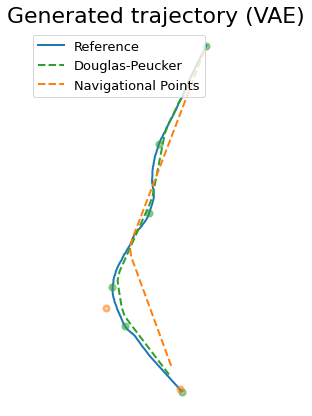

In [5]:
highlight = "TRAJ_4"

with plt.style.context("traffic"):
    ax = plt.axes(projection=EuroPP())
    ax.set_title("Generated trajectory (VAE)")
    t_gmm[highlight].plot(ax, c="tab:blue", lw=2.0, label="Reference")
    # Douglas-Peucker
    t_gmm_dp[highlight].plot(ax, mec="tab:green",mew=3.0,ms=10.0, mfc="none", marker=".", ls="", alpha=0.6)
    dp_t_sim[highlight].plot(ax, c="tab:green", ls="--", lw=2.0, label="Douglas-Peucker")
    # Navigational Points
    t_gmm_nav[highlight].plot(ax, mec="tab:orange",mew=3.0,ms=10.0, mfc="none", marker=".", ls="", alpha=0.6)
    nav_t_sim[highlight].plot(ax, c="tab:orange", ls="--", lw=2.0, label="Navigational Points")
    ax.legend(loc=0)

### Distance Computing

In [6]:
summary = t_gmm.summary(["flight_id", "callsign", "icao24", "start", "duration"])
dp_t_sim = dp_t_sim.merge(summary, on="flight_id")
t_s = dp_t_sim.summary(["flight_id", "timestamp_min"])
dp_t_sim = dp_t_sim.merge(t_s, on="flight_id").assign(
    timestamp= lambda df: df.start + (df.timestamp - df.timestamp_min) * pd.Timedelta("1s")
).compute_xy(EuroPP())
df_dp = compare_xy(dp_t_sim, t_gmm)
df_dp.to_csv("./outputs/distances/dist_gmm_dp.csv")

100%|██████████| 1000/1000 [02:58<00:00,  5.60it/s]


In [7]:
summary = t_gmm.summary(["flight_id", "callsign", "icao24", "start", "duration"])
nav_t_sim = nav_t_sim.merge(summary, on="flight_id")
t_s = nav_t_sim.summary(["flight_id", "timestamp_min"])
nav_t_sim = nav_t_sim.merge(t_s, on="flight_id").assign(
    timestamp= lambda df: df.start + (df.timestamp - df.timestamp_min) * pd.Timedelta("1s")
).compute_xy(EuroPP())
df_nav = compare_xy(nav_t_sim, t_gmm)
df_nav.to_csv("./outputs/distances/dist_gmm_nav.csv")

100%|██████████| 1000/1000 [02:57<00:00,  5.64it/s]


In [8]:
df = pd.concat(
        [
            df_dp.assign(
                generation="GMM", reconstruction="Douglas-Peucker"
            ),
            df_nav.assign(
                generation="GMM", reconstruction="Navigational Points"
            )
        ]
    )
cumul_dist_plot(df, scales = dict(dtw=(0, 1.2e6), sspd=(0, 1.5e4)), domain=["GMM"])

alt.VConcatChart(...)